<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Node-Classification-with-Graph-Neural-Networks" data-toc-modified-id="Node-Classification-with-Graph-Neural-Networks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Node Classification with Graph Neural Networks</a></span><ul class="toc-item"><li><span><a href="#Loading-a-prepared-dataset" data-toc-modified-id="Loading-a-prepared-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading a prepared dataset</a></span></li><li><span><a href="#Training-a-Multi-layer-Perception-Network-(MLP)" data-toc-modified-id="Training-a-Multi-layer-Perception-Network-(MLP)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training a Multi-layer Perception Network (MLP)</a></span></li><li><span><a href="#Training-a-Graph-Neural-Network-(GNN)" data-toc-modified-id="Training-a-Graph-Neural-Network-(GNN)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training a Graph Neural Network (GNN)</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#(Optional)-Exercises" data-toc-modified-id="(Optional)-Exercises-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>(Optional) Exercises</a></span></li></ul></li></ul></div>

In [15]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [16]:
ls data/Planetoid/Cora

processed/ raw/


#### About the Cora dataset

The Cora dataset consists of 2,708 scientific publications classified among 7 classes.

The citation network consists of 5,429 links. Each publication is described by a 0/1 binary label indicating the absence/presence of the corresponding word from the dictionary, which consists of 1,433 unique words.


- wget https://data.deepai.org/Cora.zip

- https://graphsandnetworks.com/the-cora-dataset/


In [17]:
ls Cora

edges.csv        group-edges.csv


In [18]:
import pandas as pd
df_e = pd.read_csv('Cora/edges.csv')
df_g = pd.read_csv('Cora/group-edges.csv')

In [19]:
print(df_e.shape)
print(df_g.shape)

(5428, 2)
(2707, 2)


In [20]:
print('classes:\n', df_g['Rule_Learning'].unique())

classes:
 ['Neural_Networks' 'Case_Based' 'Genetic_Algorithms' 'Theory'
 'Rule_Learning' 'Reinforcement_Learning' 'Probabilistic_Methods']


In [21]:
import os
import networkx as nx
import pandas as pd
data_dir = os.path.expanduser("~/data/cora")

#edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
#edgelist["label"] = "cites"

In [22]:
ls Cora

edges.csv        group-edges.csv


## Loading a prepared dataset

In [23]:
import torch_geometric
#help(torch_geometric.datasets.Planetoid)

In [24]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


[link text](https://)Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

In [27]:
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [28]:
type(data)

torch_geometric.data.data.Data

In [29]:
data.__dict__

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'edge_attr': None,
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'pos': None,
 'normal': None,
 'face': None,
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [30]:
data['edge_index'].shape

torch.Size([2, 10556])

In [31]:
data['x'].shape

torch.Size([2708, 1433])

In [32]:
# Number of edges
len(data['edge_index'].unique())

2708

In [33]:
# there are 7 classes coded from 0 to 6
data['y'].max(), data['y'].unique()

(tensor(6), tensor([0, 1, 2, 3, 4, 5, 6]))

In [34]:
# Each node has a class label
len(data['y'])

2708

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [35]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [36]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [37]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [203]:
type(dataset)

torch_geometric.datasets.planetoid.Planetoid

In [204]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=128)
print(model)

GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 7)
)



Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

In [207]:
model = GCN(hidden_channels=128)
model.eval()
model(data.x, data.edge_index[0:10])



tensor([[-0.0045,  0.0054, -0.0017,  ..., -0.0011,  0.0031,  0.0077],
        [-0.0023,  0.0077, -0.0016,  ..., -0.0038, -0.0003,  0.0064],
        [-0.0007,  0.0061,  0.0012,  ..., -0.0056, -0.0005,  0.0033],
        ...,
        [-0.0102,  0.0122,  0.0100,  ..., -0.0060,  0.0076,  0.0142],
        [-0.0010,  0.0074,  0.0037,  ...,  0.0020, -0.0023,  0.0064],
        [-0.0007,  0.0050,  0.0023,  ...,  0.0015, -0.0027,  0.0061]],
       grad_fn=<AddBackward0>)

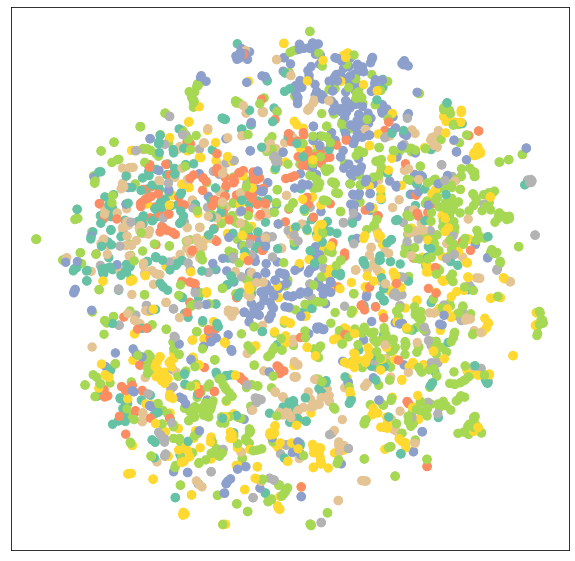

In [205]:
model = GCN(hidden_channels=128)
model.eval()

out = model(data.x, data.edge_index[0:10])
visualize(out, color=data.y)

As one can see, there is at least *some kind* of clustering (*e.g.*, for the "blue" nodes), but we certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [76]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    

Epoch: 001, Loss: 1.9450
Epoch: 002, Loss: 1.9274
Epoch: 003, Loss: 1.9058
Epoch: 004, Loss: 1.8811
Epoch: 005, Loss: 1.8508
Epoch: 006, Loss: 1.8209
Epoch: 007, Loss: 1.7804
Epoch: 008, Loss: 1.7431
Epoch: 009, Loss: 1.7065
Epoch: 010, Loss: 1.6538
Epoch: 011, Loss: 1.6103
Epoch: 012, Loss: 1.5544
Epoch: 013, Loss: 1.5092
Epoch: 014, Loss: 1.4438
Epoch: 015, Loss: 1.3935
Epoch: 016, Loss: 1.3423
Epoch: 017, Loss: 1.2919
Epoch: 018, Loss: 1.2209
Epoch: 019, Loss: 1.1530
Epoch: 020, Loss: 1.1046
Epoch: 021, Loss: 1.0324
Epoch: 022, Loss: 0.9901
Epoch: 023, Loss: 0.9436
Epoch: 024, Loss: 0.8968
Epoch: 025, Loss: 0.8557
Epoch: 026, Loss: 0.7958
Epoch: 027, Loss: 0.7511
Epoch: 028, Loss: 0.7085
Epoch: 029, Loss: 0.6887
Epoch: 030, Loss: 0.6368
Epoch: 031, Loss: 0.6148
Epoch: 032, Loss: 0.5767
Epoch: 033, Loss: 0.5449
Epoch: 034, Loss: 0.5388
Epoch: 035, Loss: 0.5078
Epoch: 036, Loss: 0.4682
Epoch: 037, Loss: 0.4719
Epoch: 038, Loss: 0.4332
Epoch: 039, Loss: 0.4430
Epoch: 040, Loss: 0.4153


After training the model, we can check its test accuracy:

In [77]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8060


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.4% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

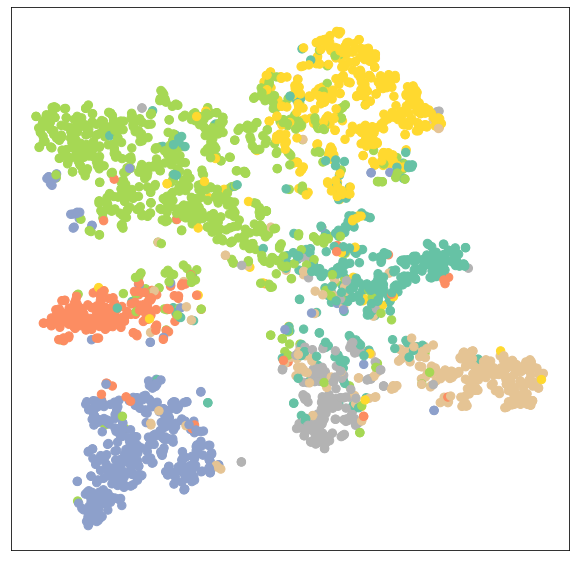

In [78]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Generate feature vectors for a given document

In [143]:
data.x.shape

torch.Size([2708, 1433])

In [79]:
model.forward(data.x, data.edge_index).shape

torch.Size([2708, 7])

In [201]:
model.conv1(data.x, data.edge_index).shape

torch.Size([2708, 128])

In [ ]:
model.conv1(data.x[], data.edge_index).shape

In [86]:
model.conv1, model.conv2

(GCNConv(1433, 128), GCNConv(128, 7))

Let us consider all the adjacent nodes to node 24

In [255]:
import numpy as np

node_k = 1
print((data.edge_index[0]==node_k).sum())
print((data.edge_index[1]==node_k).sum())

max_index = node_indices.max()

row_1_ind = data.edge_index[1] == node_k
data.edge_index[:,row_1_ind]
row_0_ind = data.edge_index[0] == node_k
data.edge_index[:,row_0_ind]

n_neighbors = int(row_0_ind.sum() + row_1_ind.sum())
edge_index_sub = torch.hstack( [data.edge_index[:,row_0_ind],
                                data.edge_index[:,row_1_ind]])

node_indices = edge_index_sub.unique()
print('unique indices:', node_indices)
print('max index',node_indices.max())
max_index = node_indices.max()

tensor(3)
tensor(3)
unique indices: tensor([  1,   2, 652, 654])
max index tensor(654)


In [257]:
row_0_ind = data.edge_index[0] == node_k
data.edge_index[:,row_0_ind]

tensor([[  1,   1,   1],
        [  2, 652, 654]])

In [258]:
row_1_ind = data.edge_index[1] == node_k
data.edge_index[:,row_1_ind]

tensor([[  2, 652, 654],
        [  1,   1,   1]])

In [259]:
n_neighbors = int(row_0_ind.sum() + row_1_ind.sum())
edge_index_sub = torch.hstack( [data.edge_index[:,row_0_ind],
                                data.edge_index[:,row_1_ind]])

In [260]:
edge_index_sub

tensor([[  1,   1,   1,   2, 652, 654],
        [  2, 652, 654,   1,   1,   1]])

In [261]:
node_indices = edge_index_sub.unique()
print('unique indices:', node_indices)
print('max index',node_indices.max())
max_index = node_indices.max()

unique indices: tensor([  1,   2, 652, 654])
max index tensor(654)


In [262]:
model.forward(data.x[0:max_index+1,:], 
              edge_index_sub)

tensor([[-0.0042,  0.0017, -0.0053,  ...,  0.0072,  0.0104,  0.0112],
        [-0.0045,  0.0084, -0.0038,  ..., -0.0053,  0.0009,  0.0086],
        [-0.0022,  0.0042, -0.0026,  ..., -0.0043, -0.0001,  0.0058],
        ...,
        [-0.0053,  0.0085, -0.0051,  ..., -0.0037,  0.0026,  0.0061],
        [ 0.0161,  0.0147, -0.0041,  ..., -0.0135,  0.0149, -0.0030],
        [-0.0022,  0.0062, -0.0009,  ..., -0.0046, -0.0002,  0.0086]],
       grad_fn=<AddBackward0>)

Note that in order to do the forward pass you need a subset of the matrix containing the maximum index from the list of edges `edge_index_sub`

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?